In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file=tf.keras.utils.get_file('Breast_Cancer.csv',URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df=pd.read_csv(data_file,names=col_names,header=None)
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df.pop('id')

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

In [4]:
df['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'],
      dtype=object)

In [5]:
df=df[df['bare_nuclei']!='?']
df['bare_nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '5', '8', '6'], dtype=object)

In [6]:
df.bare_nuclei=pd.to_numeric(df.bare_nuclei)

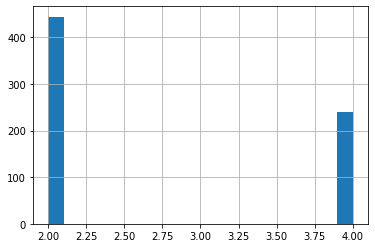

In [7]:
df['class'].hist(bins=20)

In [8]:
df['class']=np.where(df['class']==2,0,1)

In [9]:
train,test=train_test_split(df,test_size=0.2)

In [10]:
train_stats=train.describe()
train_stats.pop('class')
train_stats=train_stats.transpose()

In [11]:
train_y=train.pop('class')
test_y=test.pop('class')

In [12]:
def normalize(x):
  return(x-train_stats['mean'])/train_stats['std']

In [13]:
norm_train_x=normalize(train)
norm_test_x=normalize(test)

In [14]:
train_df=tf.data.Dataset.from_tensor_slices((norm_train_x.values,train_y.values))
test_df=tf.data.Dataset.from_tensor_slices((norm_test_x.values,test_y.values))

In [15]:
batch_size=32
train_df=train_df.shuffle(buffer_size=len(train)).batch(batch_size=batch_size)
test_df=test_df.batch(batch_size=batch_size)

In [16]:
a=enumerate(train_df)
print(len(list(a)))

18


In [17]:
def base_model():
  inputs=tf.keras.layers.Input(shape=(len(norm_train_x.columns)))
  x=Dense(64,activation='relu')(inputs)
  x=Dense(64,activation='relu')(x)
  outputs=Dense(1,activation='sigmoid')(x)
  model=Model(inputs=inputs,outputs=outputs)
  return model

In [18]:
model=base_model()

In [19]:
optimizer=tf.keras.optimizers.Adam()
loss_object=tf.keras.losses.BinaryCrossentropy()

In [20]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [21]:
class F1score(tf.keras.metrics.Metric):
  def __init__(self,name='f1score',**kwargs):
    super(F1score,self).__init__(name=name,**kwargs)
    self.fp=tf.Variable(0,dtype='int32')
    self.tn=tf.Variable(0,dtype='int32')
    self.fn=tf.Variable(0,dtype='int32')
    self.tp=tf.Variable(0,dtype='int32')

  def update_state(self,y_true,y_pred,sample_weight=None):
    conf_matrix=tf.math.confusion_matrix(y_true,y_pred,num_classes=2)
    self.tn.assign_add(conf_matrix[0][0])
    self.tp.assign_add(conf_matrix[1][1])
    self.fp.assign_add(conf_matrix[0][1])
    self.fn.assign_add(conf_matrix[1][0])
  
  def result(self):
    if(self.tp+self.fp==0):
      precision=1
    else:
      precision=self.tp/(self.tp+self.fp)
    
    if(self.tp+self.fn==0):
      recall=1
    else:
      recall=self.tp/(self.tp+self.fn)
    f1_score=2*((precision*recall)/(precision+recall))
    return f1_score
  def reset_states(self):
    self.tp.assign(0)
    self.tn.assign(0)
    self.fn.assign(0)
    self.fp.assign(0)

In [22]:
train_f1score_metric = F1score()
val_f1score_metric = F1score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [23]:
def apply_gradient(loss_object,x,y,optimizer):
  with tf.GradientTape() as t:
    logits=model(x)
    loss=loss_object(y,logits)
    gradients=t.gradient(loss,model.trainable_weights)
    optimizer.apply_gradients(zip(gradients,model.trainable_weights))
    return logits,loss

In [24]:
def train_per_epoch(train_df,optimizer,loss_object,model,train_acc_metric,train_f1score_metric):
  losses=[]
  for step,(x_train_batch,y_train_batch) in enumerate(train_df):
    logits,loss_value=apply_gradient(loss_object,x_train_batch,y_train_batch,optimizer)
    losses.append(loss_value)
    logits=tf.round(logits)
    logits=tf.cast(logits,dtype='int32')
    train_acc_metric.update_state(y_train_batch, logits)
    train_f1score_metric.update_state(y_train_batch, logits)
  return losses

In [25]:
def validation():
  losses=[]
  for x_val,y_val in test_df:
    val_logits=model(x_val)
    val_loss=loss_object(y_val,val_logits)
    losses.append(val_loss)
    val_logits=tf.round(val_logits)
    val_logits=tf.cast(val_logits,dtype='int32')
    val_acc_metric.update_state(y_val,val_logits)
    val_f1score_metric.update_state(y_val,val_logits)
  return losses


In [26]:
epochs=5
epochs_val_losses,epochs_train_losses=[],[]
for epoch in range(epochs):
  print('\nstart of epoch %d'%(epoch+1))
  losses_train=train_per_epoch(train_df,optimizer,loss_object,model,train_acc_metric,train_f1score_metric)
  train_acc=train_acc_metric.result()
  train_f1=train_f1score_metric.result()
  losses_val=validation()
  val_acc=val_acc_metric.result()
  val_f1=val_f1score_metric.result()
  loss_train_mean=np.mean(losses_train)
  loss_val_mean=np.mean(losses_val)
  epochs_val_losses.append(loss_val_mean)
  epochs_train_losses.append(loss_train_mean)
  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch+1, float(loss_train_mean), float(loss_val_mean), float(train_acc), float(val_acc), train_f1, val_f1))
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()
  val_f1score_metric.reset_states()
  train_f1score_metric.reset_states()


start of epoch 1

 Epoch 1: Train loss: 0.5742  Validation Loss: 0.3600, Train Accuracy: 0.7448, Validation Accuracy 0.9812, Train F1 Score: 0.6852, Validation F1 Score: 0.9677

start of epoch 2

 Epoch 2: Train loss: 0.2641  Validation Loss: 0.1691, Train Accuracy: 0.9705, Validation Accuracy 0.9688, Train F1 Score: 0.9572, Validation F1 Score: 0.9451

start of epoch 3

 Epoch 3: Train loss: 0.2011  Validation Loss: 0.0933, Train Accuracy: 0.9219, Validation Accuracy 0.9688, Train F1 Score: 0.9618, Validation F1 Score: 0.9451

start of epoch 4

 Epoch 4: Train loss: 0.0984  Validation Loss: 0.0786, Train Accuracy: 0.9740, Validation Accuracy 0.9625, Train F1 Score: 0.9614, Validation F1 Score: 0.9333

start of epoch 5

 Epoch 5: Train loss: 0.0838  Validation Loss: 0.0710, Train Accuracy: 0.9740, Validation Accuracy 0.9625, Train F1 Score: 0.9614, Validation F1 Score: 0.9333


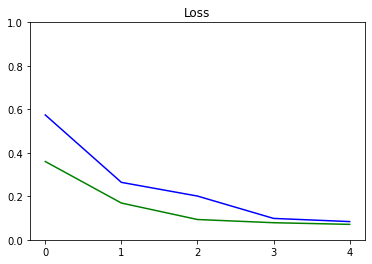

In [27]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

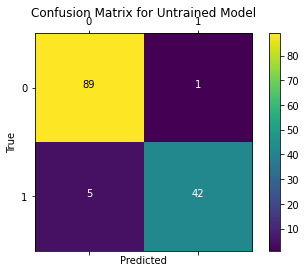

In [28]:
test_outputs = model(norm_test_x.values)
plot_confusion_matrix(test_y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')